In [18]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import time
import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import Image
import matplotlib.font_manager as fm
fm.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rc('font', family='D2Coding')
import scipy.stats as stats

<b><span style="color:white; background-color:red; font-size:150%">마크다운</span></b>

<b><span style="color:black; background-color:yellow; font-size:200%">게임 Battle Ground의 pc, 모바일, steam 별 인기순위를 분석하는 모형</span></b>


# BATTLEGROUNDS 란?

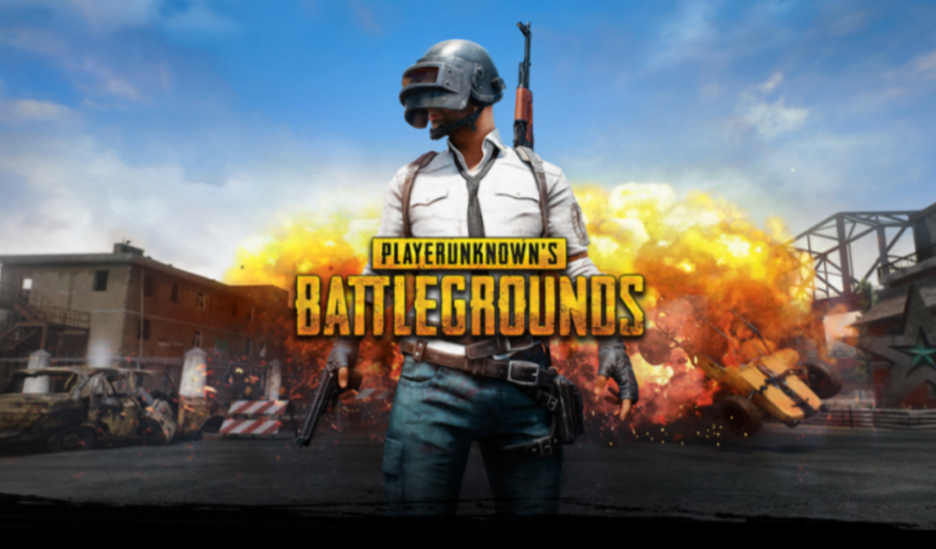

## BATTLEGROUNDS 기본 지식
<BATTLEGROUND 기본 지식>
- 간단한 설명 :
크래프톤의 자회사인 펍지 스튜디오의 MMO (대규모 멀티플레이형 게임) 슈팅 게임,
공식 명칭은' PUBG : BATTLEGROUNDS '약칭 배틀그라운드이며 더 줄여서 배그라고 불리어 짐
배틀그라운드는 최대 100명이 한 전장에서 싸워 최후의 1인 생존자를 가리는 게임이여서 충분한 이용자수가 담보돼야 원활한 게임 플레이가 가능
- 인기 :
스팀을 통해 전세계 동시 출시를 하였으며,
300 만 명이 넘는 스팀역사상 최다 동접자기록을 세우면서 배틀로얄 게임 시대를 열었다는 평가를 받고 있음
- 장르 : 배틀로얄
- 유통사 : 우리나라 = KRAFRON 크래프톤, 카카오게임즈

## 분석 동기 및 이유

In [7]:
pc14 = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/the_log_data_manufac_csv/the_log_gamename_top.csv')
pc14.head(15)

,name,name.1
0,서든어택,286
1,아이온,286
2,메이플스토리,286
3,배틀그라운드,286
4,던전앤파이터,286
5,사이퍼즈,286
6,스타크래프트 리마스터,286
7,리니지,286
8,스타크래프트2,286
9,오버워치,286


__pc방 점유율에서 변하지 않는 14개 게임을 분석하던 중, 가장 변동률이 큰 배틀 그라운드가 눈에 띄었다.__

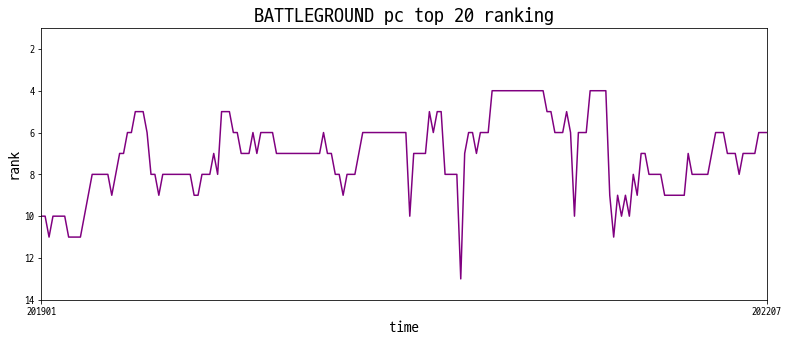

In [8]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1, 1, 1)
x=dfpop_p_bg['week_num']
y=dfpop_p_bg['rank']
plt.plot(x,y,
         color='purple')
plt.title('BATTLEGROUND pc top 20 ranking',size=20)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.xlim(0,185)
plt.ylim(14,1)
# ticklabel=['201811','202207']
ax.set_xticks([185,0],[202207,201901])
# ax.set_yticks([20,19,18,17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

BATTLEGROUNDS는 우리가 찾을 수 있는 pc, 모바일, 스팀 데이터 플랫폼에 모두 있는 게임이기 때문에 **상관관계**를 분석하기에 좋은 모델이라고 판단했다.  
그리고 팀원 중 BATTLEGROUNDS 게임 유저가 있었기 때문에 관련 배경지식을 쉽게 이해할 수 있었다.

# BATTLEGROUNDS data 수집 - DF 보여주기

data 수집방법 - 크롤링  
사유: 정리되어져 있는 파일이 없었기 때문에, 특정 사이트들에서 가져올 수 밖에 없었음

크롤링을 통해서만 데이터를 수집하기로 결정.  
훗날 후회하는 계기가 됨...

*크롤링 으로 csv 파일로 저장함  
크롤링방법  
1. Instant Data Scraper  
2. 셀레니움, 파이썬

##  y축
<국민트리>
- 사이트소개 :
빅데이터를 집계, 국민트리 유저 평점 집계, 프로게이머와 랭커들이 사용하는 덱, 직업 순위를 토대로 최신 게임 순위 제공
매일 출시 되는 인기 게임들의 정보를 추가
각 게임의 프로게이머 또는 랭커들과 같이 고수들이 사용하는 정보들을 수집하여 게임 공략을 제작
- 기준 선정 이유 :
pc, 모바일, 스팀의 매월 혹은 매주의 인기 순위의 데이터를 얻을 수 있었기 때문에 선정
- 신용 /신뢰
네이버, 구글의 검색 빅데이터를 매월 집계하여 낸 결과 값으로 신뢰할 수 있다고 판단함
다양한 컨텐츠를 제공하여 많은 게임 유저들이 이용할 것이라고 판단함


In [104]:
dfpop_p[['rank','name','company','type']].tail(5)

,rank,name,company,type
3715,16,마비노기,㈜넥슨코리아,MMORPG
3716,17,테일즈런너,㈜스마일게이트메가포트,레이싱
3717,18,오버워치,블리자드 엔터테인먼트,팀 기반 슈팅
3718,19,바람의나라,㈜넥슨코리아,MMORPG
3719,20,리니지,㈜엔씨소프트,MMORPG


## x축

### pc방 인기순위, 점유율 (가입하면 무료)
the log : https://www.thelog.co.kr/index.do  
- 전국 pc방의 실제 데이터를 실시간으로 집계하여 확인하여 게임 시장의 흐름과 데이터를 분석해줌  
- 전국 게토 PC방의 실제 데이터와 이를 기반으로 지역 분포수에 맞춘 시장 전체 표본데이터를 제공

In [108]:
# pc방_df.tail
dfpc[['rank','name','genre','distributor']].tail(5) 

,rank,name,genre,distributor
8575,26,검은사막,RPG,(주)펄어비스
8576,27,블레이드 & 소울,RPG,엔씨소프트
8577,28,크레이지아케이드,아케이드,넥슨
8578,29,엘소드,RPG,넥슨
8579,30,카운터-스트라이크 온라인,FPS,넥슨


In [8]:
# pc방 점유율_df_항목

rank : pc방 점유율 순위
name : 게임명
genre : 장르
distributor : 유통사

### 모바일 인기순위, 수익, 유저 (일정기간까지 무료로 볼 수 있음)
mobileindex : https://www.mobileindex.com/mi-chart/weekly-rank/revenue #수익
              https://www.mobileindex.com/mi-chart/weekly-rank/user #유저
- 사이트 소개 : 국내 유일의 DMP 기반 앱 분석 서비스
앱 이용성 및 심화 분석 데이터, 경쟁앱 교차 분석 데이터 등과 앱 마켓 분석 데이터를 통해 선명한 모바일 시장 분석 데이터 제공  
- 신용/신뢰 :
구글, 삼성전자, 네이버, 쿠팡 등 대기업이 금액을 지불하여 data를 가져온 것으로 보아 신뢰도 있는 데이터를 제공하는 것으로 보여짐

In [109]:
# 모바일_df.tail()
dfr[['rank','app_name']].tail(5)

,rank,app_name
4015,26,한게임 포커
4016,27,뮤오리진3
4017,28,세븐나이츠 레볼루션
4018,29,제2의 나라: Cross Worlds
4019,30,R2M


In [20]:
# 모바일_df_항목

rank : 모바일 수익 순위 / 모바일 유저 순위
app_name : 게임 이름

### 아프리카 인기순위, 방송 점유율 (일정기간까지 무료로 볼 수 있음)
아프리카 : https://gameranking.afreecatv.com/
- 2016년부터 곰eXP의 간판 e스포츠 대회였던 글로벌 스타크래프트 ll 리그 (GSL)를 인수인계하여 본격적인 e스포츠 사업을 시작하였음  
이후 GSL 뿐만 아니라 다양한 e스포츠 대회 및 이벤트를 실시하거나 타사의 e스포츠 대회 스트리밍 서비스를 계속하고 있음
아프리카TV 배틀그라운드 (APL)를 제작하고 있음  
- 신용/신뢰 :
아프리카 TV 방송 점유율 60% + 아프리카 TV PC방 게임 사용시간 점유율 40%를 합산하여 순위를 산정함
비회원, 중계방, 멀티뷰, 모바일을 모두 포함하여 집계


In [110]:
# 아프리카_df.tail()
dfa[['broad_rank','name','broad_share']].tail(5)

,broad_rank,name,broad_share
4285,26,테일즈런너,0.2%
4286,27,던파,0.2%
4287,28,R2,0.1%
4288,29,오버워치,0.1%
4289,30,거상,0.1%


In [23]:
# 아프리카_df_항목
broad_rank : 방송 점유 순위
name : 게임명
broad_share : 방송 점유율 

# 데이터 전처리

크롤링한 데이터의 경우에는 데이터 전처리가 필요

'항목'에 따른 데이터 처리_예시
- 항목 : week_num ... 


In [ ]:
dfr['week_num'] = 133 - dfr.index // 30

__2022년 7월 마지막주를 0으로 하여 역방향으로 숫자를 부여하였다.__

# BATTLEGROUNDS 데이터 분석

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import time
import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import Image

## BATTLEGROUNDS  DataFrame 가져오기 -> GRAPH 보여줌=시각화

In [4]:
#github에 모두 push 한 후 가져오기

# 기준data
#game popularity ranking
dfpop_p = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/game_tree_graph/pretty_pc_graph.csv',encoding = 'utf-8') #pc 인기순위
dfpop_m = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/game_tree_graph/pretty_mobile_graph.csv',encoding = 'utf-8') #모바일 인기순위
dfpop_s = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/game_tree_graph/pretty_steam_graph.csv',encoding = 'utf-8') #스팀 인기순위
                                              # 스팀
                                              # - 비교변수를 찾지 못함 
                                              # - 하지만 BATTLEGROUNDS 게임이 'steam' 에도 있기 때문에 종속변수들 사이에서도 영향이 있을 것으로 추정되어 데이터를 가져오게 되었음


# 변수data
#pc_room 
dfpc = pd.read_csv("C:/Users/X1Carbon/Documents/dev/gameData/the_log_data_manufac_csv/the_log_weeknum.csv",encoding='utf-8')

#모바일
dfr = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/mobile_revenue/mobile_revenue_rank_30.csv',encoding='utf-8') #모바일 수익
dfu = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/mobile_user/mobile_user_rank_30.csv',encoding='utf-8') #모바일 유저

#아프리카tv: 인터넷방송 (pc, 모바일 같이 있는 data, 하지만 거의 pc가 점유율이 높음)
dfa = pd.read_csv('C:/Users/X1Carbon/Documents/dev/gameData/ffinalafreecatv.csv') 

In [5]:
dfr['week_num'] = 133 - dfr.index // 30
dfu['week_num'] = 133 - dfu.index // 30

## DataFrame  

- 각 데이터를 합쳐서 사용하지 않고 각 플랫폼(pc,모바일,steam)으로 나누어 비교함
- 기준 vs 기준
- 기준 vs 변수
- 변수 vs 변수

In [6]:
dfa_bg = dfa.loc[dfa['name'] == '배틀그라운드']
dfu_bg = dfu.loc[dfu['app_name'] == '배틀그라운드']
dfr_bg = dfr.loc[dfr['app_name'] == '배틀그라운드']
dfpop_m_bg = dfpop_m.loc[dfpop_m['name'] == '배틀그라운드 모바일']
dfpop_p_bg = dfpop_p.loc[dfpop_p['name'] == '배틀그라운드']
dfpop_s_bg = dfpop_s.loc[dfpop_s['name'] == '플레이어언노운스 배틀그라운드']
dfpc_bg = dfpc.loc[dfpc['name'] == '배틀그라운드']

### 기준 vs 기준

#### pc 인기순위 vs 스팀 인기순위 vs 모바일 인기순위

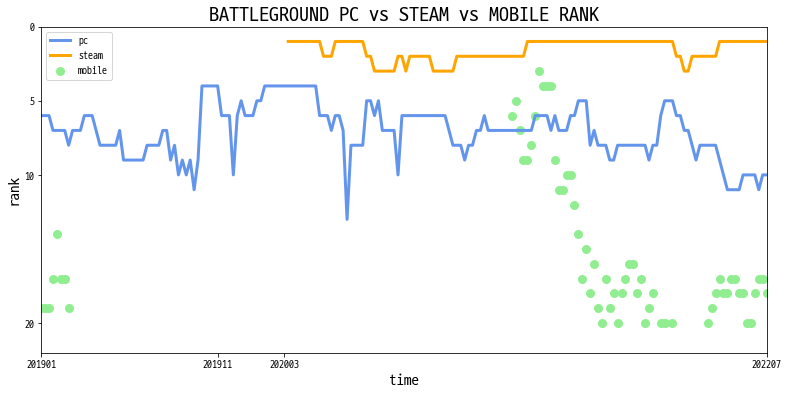

In [40]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpop_p_bg['week_num'],dfpop_p_bg['rank'], label='pc',color='cornflowerblue',linewidth=3)
plt.plot(dfpop_s_bg['week_num'],dfpop_s_bg['rank'], label='steam',color='orange',linewidth=3)
plt.scatter(dfpop_m_bg['week_num'],dfpop_m_bg['rank'], color = 'lightgreen', label='mobile',linewidth=3)
# sns.swarmplot(data=dfpop_m_bg, x="week_num", y="rank")
plt.title('BATTLEGROUND PC vs STEAM vs MOBILE RANK',size=20)
plt.ylim(22,0)
plt.xlim(185,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([185,140,123,0],[201901,201911,202003,202207])
ax.set_yticks([20,10,5,0])
plt.show()

**pc와 모바일 배틀 그라운드가 역의 상관관계가 있을 것이라고 생각했던 것과는 다르게,  
서로 관계를 찾을 수 없었습니다.**

### 기준 vs 변수

<b><span style="color:black; background-color:aliceblue; font-size:120%">기준 : pc 인기순위</span></b>

#### pc 인기순위 vs pc 방

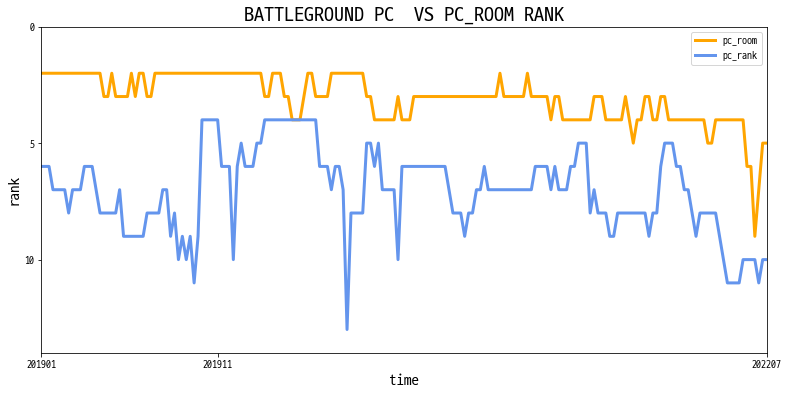

In [41]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpc_bg['week_num'],dfpc_bg['rank'],label = 'pc_room',color='orange',linewidth=3)
plt.plot(dfpop_p_bg['week_num'],dfpop_p_bg['rank'], label = 'pc_rank',color='cornflowerblue',linewidth=3)
plt.title('BATTLEGROUND PC  VS PC_ROOM RANK',size=20)
plt.ylim(14,0)
plt.xlim(185,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([185,140,0],[201901,201911,202207])
ax.set_yticks([10,5,0])
plt.show()

#### pc 인기순위 vs 모바일 수익

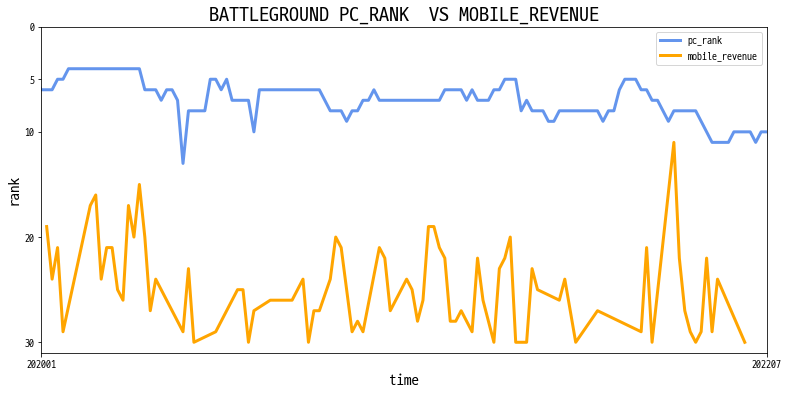

In [42]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpop_p_bg['week_num'],dfpop_p_bg['rank'], label = 'pc_rank',color='cornflowerblue',linewidth=3)
plt.plot(dfr_bg['week_num'],dfr_bg['rank'], label = 'mobile_revenue',color='orange',linewidth=3)
plt.title('BATTLEGROUND PC_RANK  VS MOBILE_REVENUE',size=20)
plt.ylim(31,0)
plt.xlim(133,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend()
ax.set_xticks([133,0],[202001,202207])
ax.set_yticks([30,20,10,5,0])
plt.show()

#### pc 인기순위 vs 모바일 유저

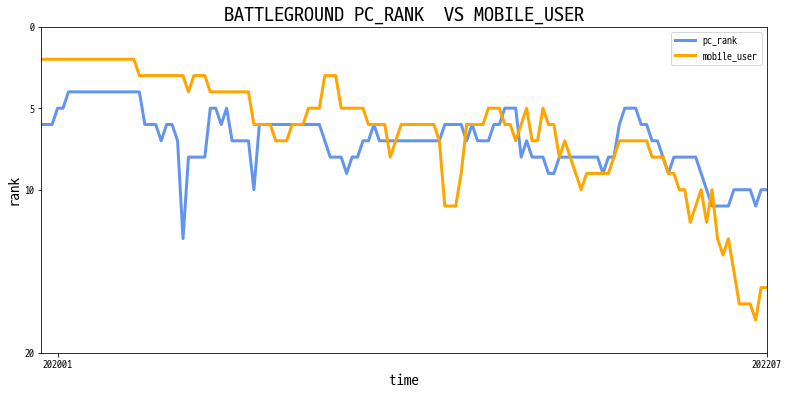

In [43]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpop_p_bg['week_num'],dfpop_p_bg['rank'], label = 'pc_rank',color='cornflowerblue',linewidth=3)
plt.plot(dfu_bg['week_num'],dfu_bg['rank'], label = 'mobile_user',color='orange',linewidth=3)
plt.title('BATTLEGROUND PC_RANK  VS MOBILE_USER',size=20)
plt.ylim(20,0)
plt.xlim(133,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend()
ax.set_xticks([130,0],[202001,202207])
ax.set_yticks([20,10,5,0])
plt.show()

In [120]:
i = dfpop_p[dfpop_p['week_num']>133].index
dfpop_p2=dfpop_p.drop(i)
dfpop_p2_bg=dfpop_p2.loc[dfpop_p2['name']=='배틀그라운드']

In [121]:
# 배그의 모바일 사용자수와 pc 순위의 상관관계 검정
dfu_bg=dfu.loc[dfu['app_name']=='배틀그라운드']
dfpop_p2_bg=dfpop_p2.loc[dfpop_p2['name']=='배틀그라운드']
corr_p=stats.pearsonr(dfu_bg['rank'],dfpop_p2_bg['rank'])
corr_p

(0.6588994897584821, 4.968724663571773e-18)

**유의수준이 0.05일때, 상관관계 검정의 p값이 0.05보다 작았습니다.  
따라서 배그의 pc 순위와 모바일 유저수는 상관이 있다고 할 수 있습니다.**  


#### pc 인기순위 vs 아프리카tv

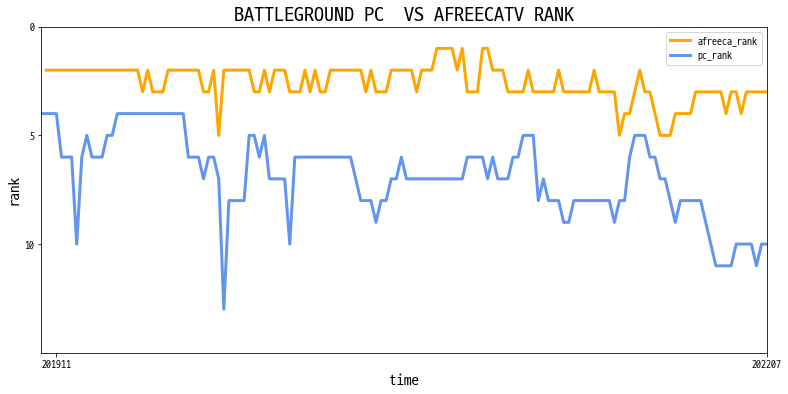

In [44]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfa_bg['week_num'],dfa_bg['broad_rank'],label = 'afreeca_rank',color='orange',linewidth=3)
plt.plot(dfpop_p_bg['week_num'],dfpop_p_bg['rank'],label = 'pc_rank',color='cornflowerblue',linewidth=3)
plt.title('BATTLEGROUND PC  VS AFREECATV RANK',size=20)
plt.ylim(15,0)
plt.xlim(143,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([140,0],[201911,202207])
ax.set_yticks([10,5,0])
plt.show()

In [118]:
# 배그의 아프리카 tv 방송 순위와 pc 순위의 상관관계 검정

i = dfpop_p[dfpop_p['week_num']>142].index
dfpop_p1=dfpop_p.drop(i)
dfpop_p1_bg=dfpop_p1.loc[dfpop_p1['name']=='배틀그라운드']
corr_p=stats.pearsonr(dfa_bg['broad_rank'],dfpop_p1_bg['rank'])
corr_p

(0.30477054588568764, 0.00021476470927509752)

In [123]:
# 피파온라인4의 pc 순위 vs 아프리카 tv 방송 순위
dfa_f=dfa.loc[dfa['name']=='피파온라인4']
dfpop_p1_f=dfpop_p1.loc[dfpop_p1['name']=='피파온라인4']
corr_p=stats.pearsonr(dfa_f['broad_rank'],dfpop_p1_f['rank'])
corr_p

(0.15032408532295588, 0.07312737000726562)

**유의수준이 0.05일때, 상관관계 검정의 p값이 0.05보다 컸습니다.  
따라서 피파온라인4의 pc 순위와 아프리카tv 방송 점유율 순위는 상관이 있다고 할 수 없습니다.**

<b><span style="color:black; background-color:aliceblue; font-size:120%">기준 : 모바일 인기순위</span></b>

#### 모바일 인기순위 vs 모바일 수익

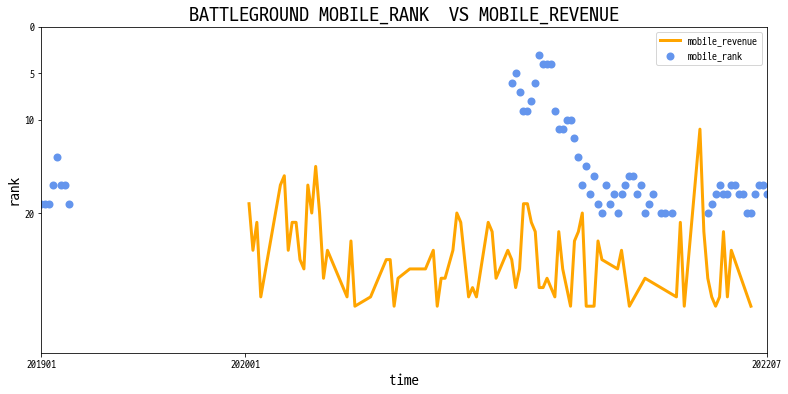

In [45]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfr_bg['week_num'],dfr_bg['rank'], label = 'mobile_revenue',color='orange',linewidth=3)
plt.scatter(dfpop_m_bg['week_num'],dfpop_m_bg['rank'], label = 'mobile_rank',color='cornflowerblue',linewidth=2)
plt.title('BATTLEGROUND MOBILE_RANK  VS MOBILE_REVENUE',size=20)
plt.ylim(35,0)
plt.xlim(185,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([185,133,0],[201901,202001,202207])
ax.set_yticks([20,10,5,0])
plt.show()

#### 모바일 인기순위 vs 모바일 유저

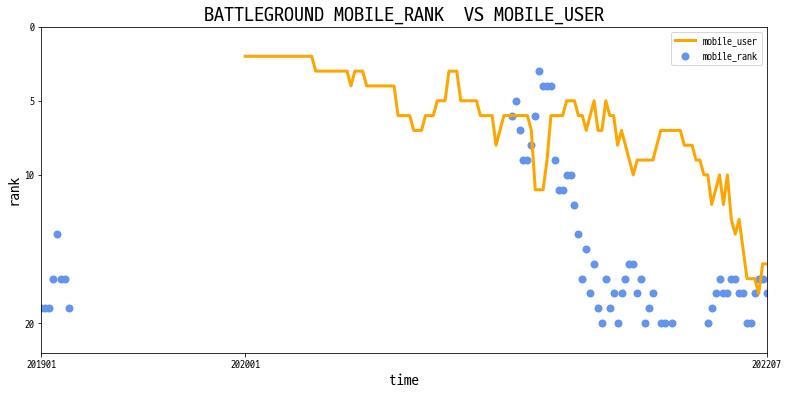

In [46]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfu_bg['week_num'],dfu_bg['rank'], label = 'mobile_user',color='orange',linewidth=3)
plt.scatter(dfpop_m_bg['week_num'],dfpop_m_bg['rank'], label = 'mobile_rank',color='cornflowerblue',linewidth=2)
plt.title('BATTLEGROUND MOBILE_RANK  VS MOBILE_USER',size=20)
plt.ylim(22,0)
plt.xlim(185,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([185,133,0],[201901,202001,202207])
ax.set_yticks([20,10,5,0])
plt.show()

#### 모바일 인기순위 vs 아프리카 tv

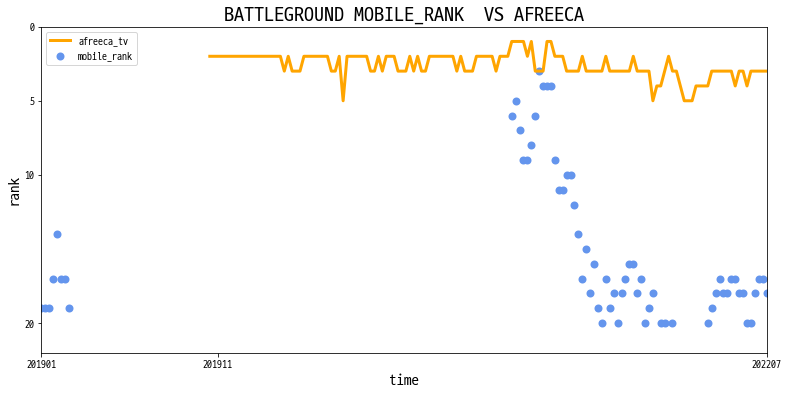

In [47]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfa_bg['week_num'],dfa_bg['broad_rank'], label = 'afreeca_tv',color='orange',linewidth=3)
plt.scatter(dfpop_m_bg['week_num'],dfpop_m_bg['rank'], label = 'mobile_rank',color='cornflowerblue',linewidth=2)
plt.title('BATTLEGROUND MOBILE_RANK  VS AFREECA',size=20)
plt.ylim(22,0)
plt.xlim(185,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([185,140,0],[201901,201911,202207])
ax.set_yticks([20,10,5,0])
plt.show()

#### 모바일 수익 vs 모바일 유저

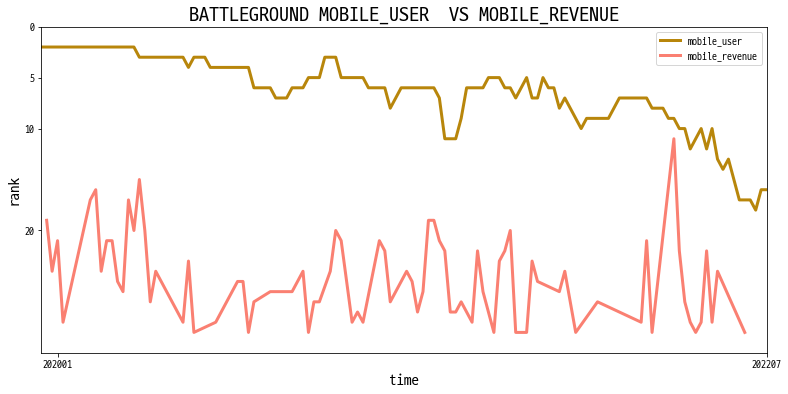

In [59]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfu_bg['week_num'],dfu_bg['rank'], label = 'mobile_user',color='darkgoldenrod',linewidth=3)
plt.plot(dfr_bg['week_num'],dfr_bg['rank'], label = 'mobile_revenue',color='salmon',linewidth=3)
plt.title('BATTLEGROUND MOBILE_USER  VS MOBILE_REVENUE',size=20)
plt.ylim(32,0)
plt.xlim(133,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([130,0],[202001,202207])
ax.set_yticks([20,10,5,0])
plt.show()

In [15]:
dfr[3990:4000][['rank','app_name','publisher_name']]

,rank,app_name,publisher_name
3990,1,우마무스메 프리티 더비,Kakao Games Corp.
3991,2,리니지M,NCSOFT
3992,3,리니지W,NCSOFT
3993,4,오딘: 발할라 라이징,Kakao Games Corp.
3994,5,FIFA ONLINE 4 M by EA SPORTS™,NEXON Company
3995,6,디아블로 이모탈,"Blizzard Entertainment, Inc."
3996,7,리니지2M,NCSOFT
3997,8,던전앤파이터 모바일,NEXON Company
3998,9,히어로즈 테일즈,37 Mobile Games
3999,10,<퍼즐 오브 Z> X 워킹 데드 콜라보!,"BLANCOZONE NETWORK CO., LIMITED"


In [16]:
dfu[3990:4000][['rank','app_name','publisher_name']]

,rank,app_name,publisher_name
3990,1,Pokémon GO,"Niantic, Inc."
3991,2,Roblox,Roblox Corporation
3992,3,피망 뉴맞고: 고스톱 대표 맞고 게임,NEOWIZ corp
3993,4,쿠키런: 킹덤,Devsisters Corporation
3994,5,브롤스타즈,Supercell
3995,6,전략적 팀 전투: 리그 오브 레전드 전략 게임,"Riot Games, Inc"
3996,7,우마무스메 프리티 더비,Kakao Games Corp.
3997,8,무한의 계단,NFLY STUDIO
3998,9,카트라이더 러쉬플러스,NEXON Company
3999,10,좀비고등학교,AWESOMEPIECE


__모바일의 경우, 수익 순위권과 유저수 순위권이 완전히 다른 모습을 볼 수 있었습니다.__

<b><span style="color:black; background-color:aliceblue; font-size:120%">기준 : 스팀 인기순위</span></b>

#### 스팀 인기순위 vs pc 방

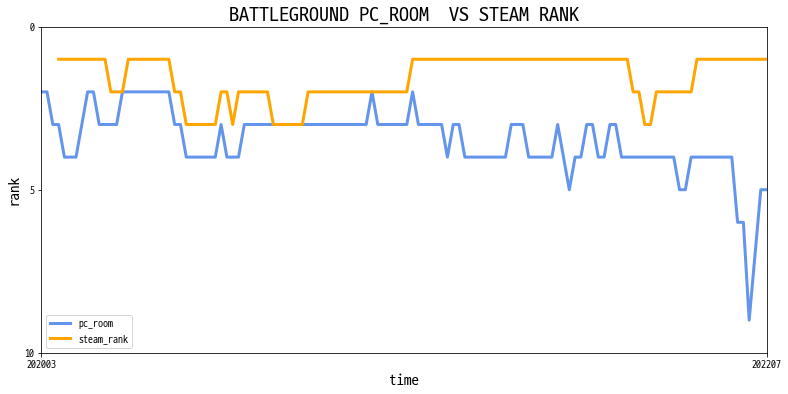

In [60]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpc_bg['week_num'],dfpc_bg['rank'], label = 'pc_room',color='cornflowerblue',linewidth=3)
plt.plot(dfpop_s_bg['week_num'],dfpop_s_bg['rank'], label = 'steam_rank',color='orange',linewidth=3)
plt.title('BATTLEGROUND PC_ROOM  VS STEAM RANK',size=20)
plt.ylim(10,0)
plt.xlim(125,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([125,0],[202003,202207])
ax.set_yticks([10,5,0])
plt.show()

#### 스팀 인기순위 vs 모바일 수익

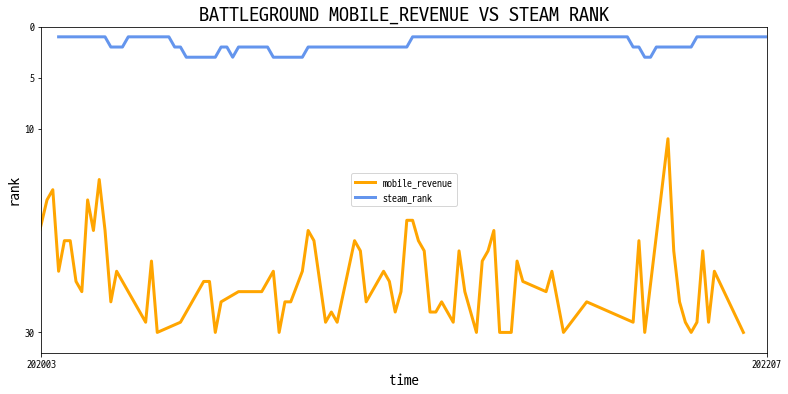

In [61]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfr_bg['week_num'],dfr_bg['rank'], label = 'mobile_revenue',color='orange',linewidth=3)
plt.plot(dfpop_s_bg['week_num'],dfpop_s_bg['rank'], label = 'steam_rank',color='cornflowerblue',linewidth=3)
plt.title('BATTLEGROUND MOBILE_REVENUE VS STEAM RANK',size=20)
plt.ylim(32,0)
plt.xlim(125,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([125,0],[202003,202207])
ax.set_yticks([30,10,5,0])
plt.show()

In [130]:
i = dfu[dfu['week_num']>122].index
dfu1=dfu.drop(i)
dfu1_bg=dfu1.loc[dfu['app_name']=='배틀그라운드']
corr_p=stats.pearsonr(dfpop_s_bg['rank'],dfu1_bg['rank'])
corr_p

(-0.2526177101237188, 0.004818386317088101)

**역의 관계가 있는 것처럼 보이지만, 스팀 랭킹은 항상 상위권에 있고 모바일 수익 랭킹은 변동이 많아 관계가 있다고 보기에는 어려워 보입니다.**

#### 스팀 인기순위 vs 아프리카tv

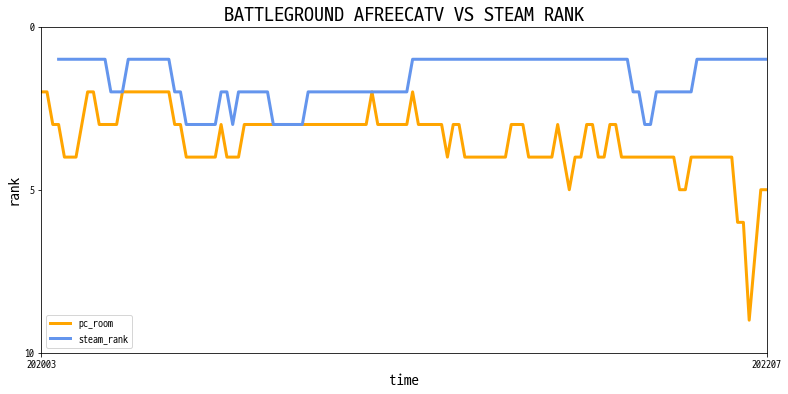

In [62]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpc_bg['week_num'],dfpc_bg['rank'], label = 'pc_room',color='orange',linewidth=3)
plt.plot(dfpop_s_bg['week_num'],dfpop_s_bg['rank'], label = 'steam_rank',color='cornflowerblue',linewidth=3)
plt.ylim(10,0)
plt.xlim(125,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([125,0],[202003,202207])
ax.set_yticks([10,5,0])
plt.title('BATTLEGROUND AFREECATV VS STEAM RANK',size=20)
plt.show()

In [127]:
i = dfa[dfa['week_num']>122].index
dfa1=dfa.drop(i)
dfa1_bg=dfa1.loc[dfa1['name']=='배틀그라운드']
corr_p=stats.pearsonr(dfa1_bg['broad_rank'],dfpop_s_bg['rank'])
corr_p

(-0.07155537887582586, 0.4315783924361228)

**유의수준이 0.05일때, 상관관계 검정의 p값이 0.05보다 컸습니다.  
따라서 배그의 스팀 순위와 아프리카tv 방송 점유율 순위는 상관이 있다고 할 수 없습니다.**

### 변수 vs 변수

#### pc 방 vs 아프리카tv

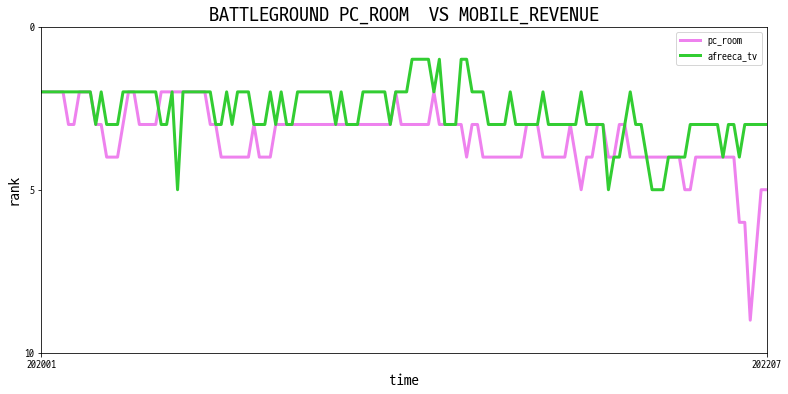

In [63]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfpc_bg['week_num'],dfpc_bg['rank'], label = 'pc_room',color='violet',linewidth=3)
plt.plot(dfa_bg['week_num'],dfa_bg['broad_rank'], label = 'afreeca_tv',color='limegreen',linewidth=3)
plt.title('BATTLEGROUND PC_ROOM  VS MOBILE_REVENUE',size=20)
plt.ylim(10,0)
plt.xlim(133,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([133,0],[202001,202207])
ax.set_yticks([10,5,0])
plt.show()

In [34]:
i = dfpc[dfpc['week_num']>142].index
dfpc1=dfpc.drop(i)
dfpc1_bg=dfpc1.loc[dfpc1['name']=='배틀그라운드']
corr_p=stats.pearsonr(dfa_bg['broad_rank'],dfpc1_bg['rank'])
corr_p

(0.40516305893433147, 5.181095763691268e-07)

#### 모바일 유저 vs 아프리카tv

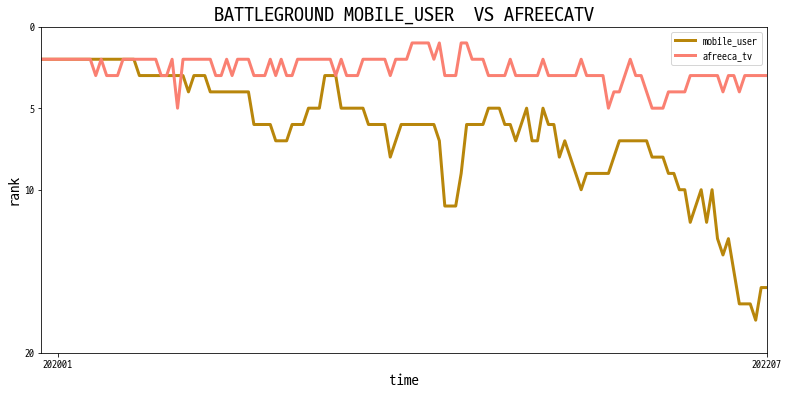

In [64]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dfu_bg['week_num'],dfu_bg['rank'], label = 'mobile_user',color='darkgoldenrod',linewidth=3)
plt.plot(dfa_bg['week_num'],dfa_bg['broad_rank'], label = 'afreeca_tv',color='salmon',linewidth=3)
plt.title('BATTLEGROUND MOBILE_USER  VS AFREECATV',size=20)
plt.ylim(20,0)
plt.xlim(133,0)
plt.xlabel('time', size=15)
plt.ylabel('rank', size=15)
plt.legend(loc='best')
ax.set_xticks([130,0],[202001,202207])
ax.set_yticks([20,10,5,0])
plt.show()

# 결론

### 같은 장르인 FPS게임과의 비교

<Figure size 936x432 with 0 Axes>

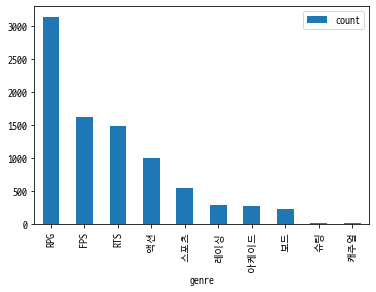

In [57]:
# data에서 genre 언급량보기
dfpc_gro = dfpc.groupby('genre')['genre'].count()
dfpc_genre = dfpc_gro.sort_values(ascending=False)
# 시리즈->판다스
dfpc_genre = pd.DataFrame(dfpc_genre)
a = dfpc_genre.columns = ['count']
a = dfpc_genre.reset_index() # 인덱스 리셋
plt.figure(figsize = (13, 6))
a.plot.bar(x='genre', y='count')
plt.show()

In [38]:
dfpc_ow = dfpc.loc[dfpc['name'] == '오버워치']
dfpc_sa = dfpc.loc[dfpc['name'] == '서든어택']

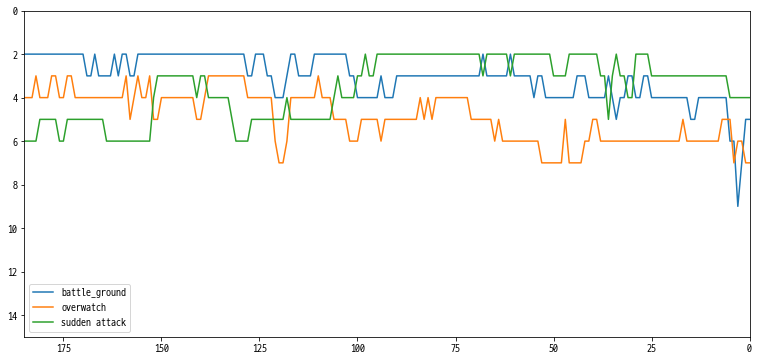

In [58]:
plt.figure(figsize = (13, 6))
plt.plot(dfpc_bg['week_num'],dfpc_bg['rank'], label = 'battle_ground')
plt.plot(dfpc_ow['week_num'],dfpc_ow['rank'], label = 'overwatch')
plt.plot(dfpc_sa['week_num'],dfpc_sa['rank'], label = 'sudden attack')
plt.ylim(15,0)
plt.xlim(185,0)
plt.legend()
plt.show()

__같은 장르인 fps게임들과 비교하였을 때, fps 게임 간 순위가 비슷한 상태로 서로 접전인 것을 확인할 수 있었습니다.   
하지만 최근 fps게임의 인기가 하락하고 있는 추세였습니다.__

In [144]:
df_article = pd.read_excel("C:/Users/X1Carbon/Desktop/hack_article_final.xlsx")
df_article[['일자','제목']]

,일자,제목
0,20220222,"""탕탕 으악"" 어디서 쏘나 했더니 게임핵 판매책 20대 집행유예"
1,20220218,게임 조작 프로그램 수억원대 유통한 20대 집행유예
2,20220218,"'게임핵' 7억원 어치 불법판매, 집행유예"
3,20220218,불법 게임 조작 프로그램 7억여원어치 유통 20대 집행유예
4,20220218,불법 게임 조작 프로그램 유통한 20대 집행유예
5,20210210,"""게임을 글로 배운 판결"" '에임핵'이 악성프로그램 아니라는 대법원에 의문 품은 판사"
6,20201112,"김경협, 게임산업진흥에 관한 법률 개정안 발의"
7,20201003,"""핵 때문에 못해먹겠다!"" 배그 떠나는 유저들"
8,20200625,배틀그라운드 ‘핵과의 전쟁’ 선포
9,20200625,“도저히 못 참겠다!” 배그 ‘핵’과의 전쟁[IT선빵!]


__분석을 하면서 가장 어려웠던 점은 기획이었습니다.  
처음 주제를 잡고 자료를 찾으려고 하자 정리되어 있는 파일이 없거나 유료였습니다. 그래서 모두 크롤링으로 자료를 수집해야 했기 때문에 시간적으로 여유가 없었습니다.  
또한 [게임 커뮤니티에서의 담론이, 게임 인기에 영향을 미치는지]를 초반 주제로 선정했었는데, 강사님과의 피드백 시간에 머신러닝까지 알아야, 텍스트 분석이 가능하다고 하셔서 주제를 바꿀 수 밖에 없었습니다.  
그래서 우리가 활용할 수 있는 숫자 데이터를 최대한 활용해서 분석을 시도해보았습니다.__  
  
__그리고 강사님께서 시각화에 대한 다양한 방법을 고민해보라고 하셨는데 이 부분이 굉장히 어려웠습니다.  
우리가 말하고자 했던 게임순위와 다양한 변수(게임의 인터넷 방송점유율, pc방 점유율 등)를 어떤 그래프를 통해 보여줄지 마지막까지 고민했지만 결국 이것 또한 우리가 가장 많이 사용해본 plot, scatter 그래프를 사용할 수 밖에 없었습니다.  
하지만 이번 프로젝트를 통해 "git을 사용한 협업 flow"와 "파이썬으로 빅데이터 전처리 하는 방법"을 보다 심도있게 알게되어서 의미있는 시간이었습니다.
감사합니다.__